# EDA Version 2

In this notebook, I will continue where I left off from v1 but will only use `data/test_data` at the moment

In [1]:
# MODULES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import sys
import os

# SCRIPTS
sys.path.append(os.path.abspath(".."))
from scripts import conversions

In [2]:
df = pd.read_csv('../data/test_data.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df

,hash,sender,recipient,value,gas_used,gas_price,timestamp,value_zscore
0,0x06dc5006e9cc13418808a35b5a6fb91378eb78c236db...,0x675bB023e268dCC43F543620577bCacB73047f08,0x5dC62cea20B0E7c3607aDCc61a885Ff9369dbc60,0.000000,223837,180.411926,2025-02-14 10:16:10,-0.011865
1,0x689d1453646e621d664836655d869d7301b8c7bcd1d4...,0x1ba98272731f1Ab5cC33a02F88694C39916E26dF,0x51C72848c68a965f66FA7a88855F9f7784502a7F,0.000000,153985,81.237520,2025-02-14 10:16:10,-0.011865
2,0x3057779542c82c2ae3f1b52b6739afe82719a61ad26c...,0x5d1783ddbb657fdf6FcC2eF5B6796Ac0DdeEb6e3,0x68d3A973E7272EB388022a5C6518d9b2a2e66fBf,0.000000,223550,65.091946,2025-02-14 10:16:11,-0.011865
3,0x0c664ea5c27efb322c1dc20c2a830b97a33fbd82b027...,0x3f22f60936F4f5D1E96cEdEb44beE66d0Cd7c220,0x98C3d3183C4b8A650614ad179A1a98be0a8d6B8E,0.000000,500002,63.063619,2025-02-14 10:16:11,-0.011865
4,0x1b386bb2f08f57a5287640e09e2f3640798a58d69a3a...,0x24f7eF98522dd61D529464f67BB3ffe96eA8AFC2,0x5dC62cea20B0E7c3607aDCc61a885Ff9369dbc60,0.000000,252997,47.995919,2025-02-14 10:16:11,-0.011865
...,...,...,...,...,...,...,...,...
99995,0x33ce94a121c1cb2b8928109fdf34fcbe148c3b4de46b...,0xf4dC8E4869B5b1Ef45F37780d436915F2e6D0151,0x91a9EB358aA171615A70c84d5Bca6C2231A9c6c8,0.042000,21000,3.373448,2025-02-14 13:42:04,-0.011651
99996,0x8bd41ebdca503d1afb58b155b43cabadc86627119b23...,0xA7EFAe728D2936e78BDA97dc267687568dD593f3,0x15bFebB0f2aD7B3B143c43F0D1D883D5243685E8,0.010190,210000,3.373448,2025-02-14 13:42:04,-0.011813
99997,0xde084d171ac01765dd4683706e660f62da1a53868708...,0xDFd5293D8e347dFe59E90eFd55b2956a1343963d,0x6055390C199b32065501c1CF03F2190790349F07,0.002996,207128,3.373448,2025-02-14 13:42:04,-0.011849
99998,0x9939fb221572e0ec19876f8d930dc1e865dd99ed9435...,0x28C6c06298d514Db089934071355E5743bf21d60,0x09A8c965E0553fE13449b7A46A681a8BC5D1A063,0.998302,207128,3.373448,2025-02-14 13:42:04,-0.006790


In [3]:
df.describe()

,value,gas_used,gas_price,value_zscore
count,100000.000000,1.000000e+05,100000.000000,100000.000000
mean,2.378115,1.990037e+05,3.891284,0.000225
std,199.287159,5.591284e+05,49.197561,1.013110
min,0.000000,2.100000e+04,1.086466,-0.011865
25%,0.000000,2.100000e+04,1.986919,-0.011865
50%,0.000000,7.580800e+04,2.591223,-0.011865
75%,0.012578,2.100000e+05,3.369946,-0.011801
max,50156.239046,2.167724e+07,13355.082496,254.965907


In [4]:
def plot_log_scatter(index, values, title, xlabel, ylabel):
    sns.set_style("whitegrid")

    plt.figure(figsize=(12, 6))

    plt.scatter(index,
                values,
                linestyle='-', 
                marker='o',
                s=1,
                alpha=0.5, 
                color='black',
                label="Transaction Value")

    # Use log scale for better visualization of outliers
    plt.yscale("log")

    plt.xticks(np.linspace(0, len(values), num=11, dtype=int))

    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16, fontweight='bold')

    plt.grid(True, linestyle='--', alpha=0.6)

    plt.legend()

    plt.show()


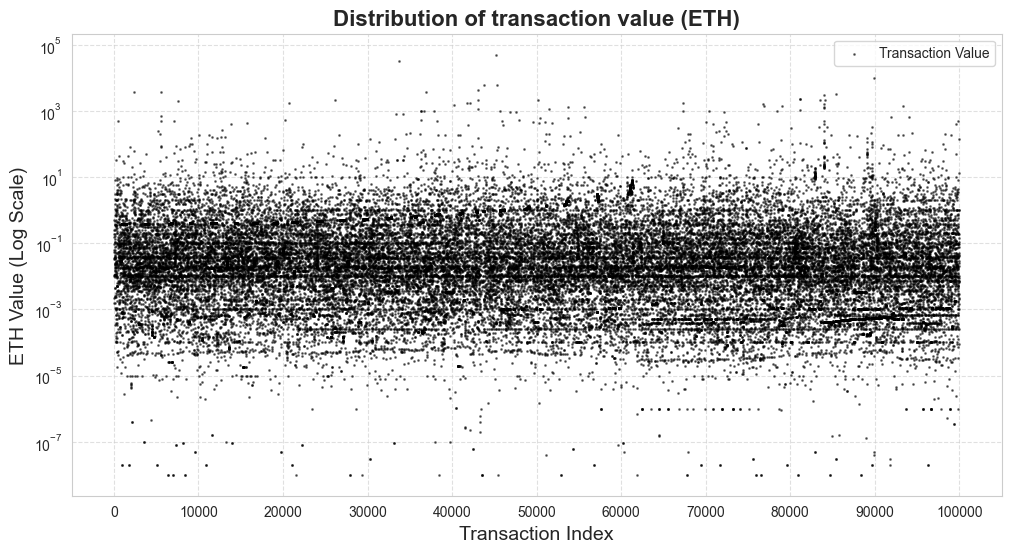

In [5]:
plot_log_scatter(df.index,
                df['value'],
                'Distribution of transaction value (ETH)',
                'Transaction Index',
                'ETH Value (Log Scale)')

The values of these transactions in ETH is actually fairly normal, and the mass seems to lean a bit heavier on the right side than the left side. We can see that there are actually just as many outliers on the left (possibly more) than there are on the right.

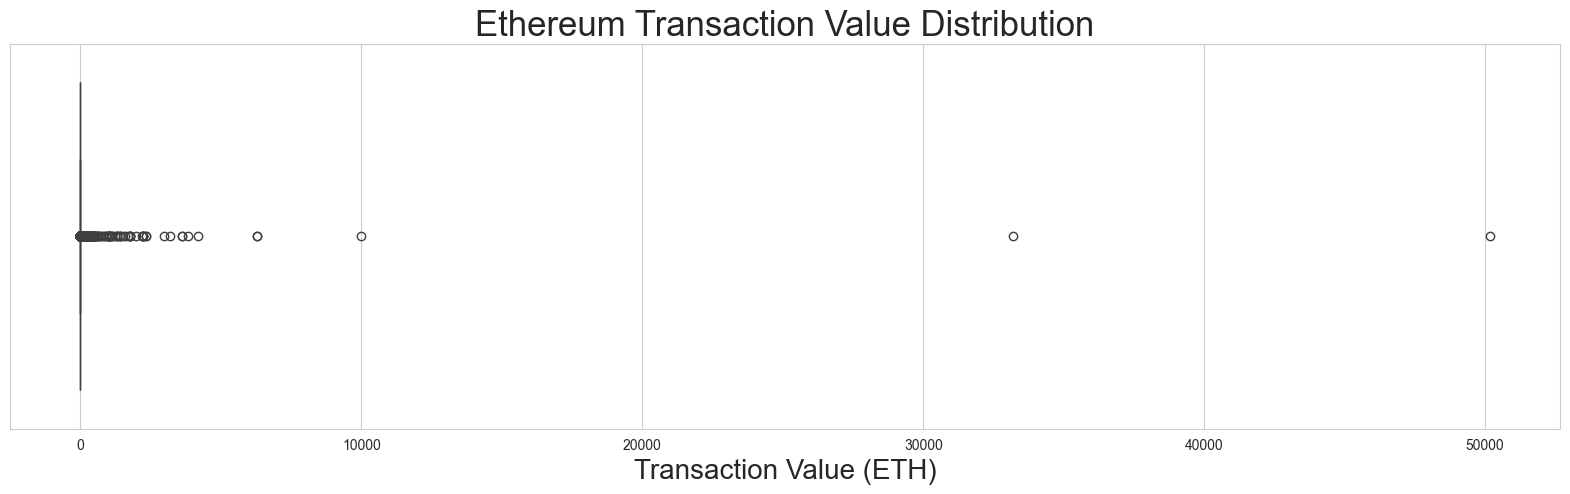

In [6]:
plt.figure(figsize=(20, 5))
sns.boxplot(x=df['value'], showfliers=True)

plt.xlabel("Transaction Value (ETH)", fontsize=20)
plt.title("Ethereum Transaction Value Distribution", fontsize=25)
plt.show()

Lets fine out where our outliers are (for the larger transactions)

In [7]:
def find_outliers(data, threshhold):
    zscores = stats.zscore(data)
    return np.where(zscores >= threshhold)[0]

outliers_gt_2 = find_outliers(df['value'], 2)
outliers_gt_3 = find_outliers(df['value'], 3)

outliers_gt_2_val = df['value'][outliers_gt_2].sort_values()
outliers_gt_3_val = df['value'][outliers_gt_3].sort_values()

In [8]:
print(f'Number of transactions with a Z-score of 2 or higher: {len(outliers_gt_2_val)}')
print('--------------------------------------------------------------------------------')
print(f'Values that are greater than a Z-score of 2:\n {outliers_gt_2_val}')

Number of transactions with a Z-score of 2 or higher: 73
--------------------------------------------------------------------------------
Values that are greater than a Z-score of 2:
 76214      410.000000
51776      422.000000
50287      428.396932
15794      442.300700
49561      448.000000
             ...     
43811     6291.495993
45329     6291.545993
89901    10000.000000
33744    33183.511741
45248    50156.239046
Name: value, Length: 73, dtype: float64


In [9]:
print(f'Number of transactions with a Z-score of 3 or higher: {len(outliers_gt_3_val)}')
print('--------------------------------------------------------------------------------')
print(f'Values that are greater than a Z-score of 3:\n {outliers_gt_3_val}')

Number of transactions with a Z-score of 3 or higher: 55
--------------------------------------------------------------------------------
Values that are greater than a Z-score of 3:
 53754      600.527052
50365      612.706523
94035      634.000000
91874      640.000000
55726      677.950000
5556       681.964490
34229      799.999300
33347      800.760000
46828      898.004042
47505      898.004078
72142      921.531963
36324      998.819958
78462      999.000000
37817      999.998500
36658     1000.000000
67298     1006.392021
70419     1006.393500
36320     1012.747727
45630     1012.748200
81187     1086.320588
43008     1109.007218
51449     1109.007556
84033     1239.999943
53744     1289.999929
55611     1290.000000
84014     1291.999895
93319     1399.997900
76901     1421.055533
78981     1421.055592
40255     1520.615121
84028     1578.168782
76816     1677.999840
41773     1749.462023
42161     1749.462143
20759     1775.000000
67301     1778.999099
7625      1963.000000
26

Having the z-score on hand in our data can be a useful feature, so lets add a column that displays it.

In [10]:
df['value_zscore'] = stats.zscore(df['value'])
df.head()

,hash,sender,recipient,value,gas_used,gas_price,timestamp,value_zscore
0,0x06dc5006e9cc13418808a35b5a6fb91378eb78c236db...,0x675bB023e268dCC43F543620577bCacB73047f08,0x5dC62cea20B0E7c3607aDCc61a885Ff9369dbc60,0.0,223837,180.411926,2025-02-14 10:16:10,-0.011933
1,0x689d1453646e621d664836655d869d7301b8c7bcd1d4...,0x1ba98272731f1Ab5cC33a02F88694C39916E26dF,0x51C72848c68a965f66FA7a88855F9f7784502a7F,0.0,153985,81.237520,2025-02-14 10:16:10,-0.011933
2,0x3057779542c82c2ae3f1b52b6739afe82719a61ad26c...,0x5d1783ddbb657fdf6FcC2eF5B6796Ac0DdeEb6e3,0x68d3A973E7272EB388022a5C6518d9b2a2e66fBf,0.0,223550,65.091946,2025-02-14 10:16:11,-0.011933
3,0x0c664ea5c27efb322c1dc20c2a830b97a33fbd82b027...,0x3f22f60936F4f5D1E96cEdEb44beE66d0Cd7c220,0x98C3d3183C4b8A650614ad179A1a98be0a8d6B8E,0.0,500002,63.063619,2025-02-14 10:16:11,-0.011933
4,0x1b386bb2f08f57a5287640e09e2f3640798a58d69a3a...,0x24f7eF98522dd61D529464f67BB3ffe96eA8AFC2,0x5dC62cea20B0E7c3607aDCc61a885Ff9369dbc60,0.0,252997,47.995919,2025-02-14 10:16:11,-0.011933


In [11]:
conversions.convert_eth_usd(df)

,hash,sender,recipient,value,gas_used,gas_price,timestamp,value_zscore,gas_cost_eth,total_cost_usd
0,0x06dc5006e9cc13418808a35b5a6fb91378eb78c236db...,0x675bB023e268dCC43F543620577bCacB73047f08,0x5dC62cea20B0E7c3607aDCc61a885Ff9369dbc60,0.000000,223837,180.411926,2025-02-14 10:16:10,-0.011933,0.040383,110.270661
1,0x689d1453646e621d664836655d869d7301b8c7bcd1d4...,0x1ba98272731f1Ab5cC33a02F88694C39916E26dF,0x51C72848c68a965f66FA7a88855F9f7784502a7F,0.000000,153985,81.237520,2025-02-14 10:16:10,-0.011933,0.012509,34.158432
2,0x3057779542c82c2ae3f1b52b6739afe82719a61ad26c...,0x5d1783ddbb657fdf6FcC2eF5B6796Ac0DdeEb6e3,0x68d3A973E7272EB388022a5C6518d9b2a2e66fBf,0.000000,223550,65.091946,2025-02-14 10:16:11,-0.011933,0.014551,39.734228
3,0x0c664ea5c27efb322c1dc20c2a830b97a33fbd82b027...,0x3f22f60936F4f5D1E96cEdEb44beE66d0Cd7c220,0x98C3d3183C4b8A650614ad179A1a98be0a8d6B8E,0.000000,500002,63.063619,2025-02-14 10:16:11,-0.011933,0.031532,86.102049
4,0x1b386bb2f08f57a5287640e09e2f3640798a58d69a3a...,0x24f7eF98522dd61D529464f67BB3ffe96eA8AFC2,0x5dC62cea20B0E7c3607aDCc61a885Ff9369dbc60,0.000000,252997,47.995919,2025-02-14 10:16:11,-0.011933,0.012143,33.157558
...,...,...,...,...,...,...,...,...,...,...
99995,0x33ce94a121c1cb2b8928109fdf34fcbe148c3b4de46b...,0xf4dC8E4869B5b1Ef45F37780d436915F2e6D0151,0x91a9EB358aA171615A70c84d5Bca6C2231A9c6c8,0.042000,21000,3.373448,2025-02-14 13:42:04,-0.011722,0.000071,114.879904
99996,0x8bd41ebdca503d1afb58b155b43cabadc86627119b23...,0xA7EFAe728D2936e78BDA97dc267687568dD593f3,0x15bFebB0f2aD7B3B143c43F0D1D883D5243685E8,0.010190,210000,3.373448,2025-02-14 13:42:04,-0.011882,0.000708,29.759564
99997,0xde084d171ac01765dd4683706e660f62da1a53868708...,0xDFd5293D8e347dFe59E90eFd55b2956a1343963d,0x6055390C199b32065501c1CF03F2190790349F07,0.002996,207128,3.373448,2025-02-14 13:42:04,-0.011918,0.000699,10.089775
99998,0x9939fb221572e0ec19876f8d930dc1e865dd99ed9435...,0x28C6c06298d514Db089934071355E5743bf21d60,0x09A8c965E0553fE13449b7A46A681a8BC5D1A063,0.998302,207128,3.373448,2025-02-14 13:42:04,-0.006924,0.000699,2727.900177


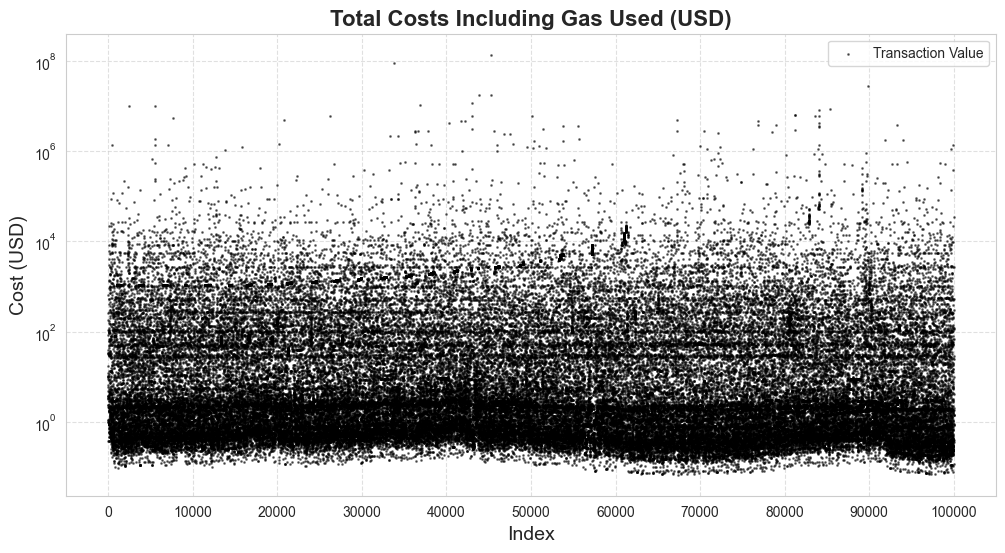

In [12]:
plot_log_scatter(df.index,
                 df['total_cost_usd'],
                 'Total Costs Including Gas Used (USD)',
                 'Index',
                 'Cost (USD)')

c:\Users\seely\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


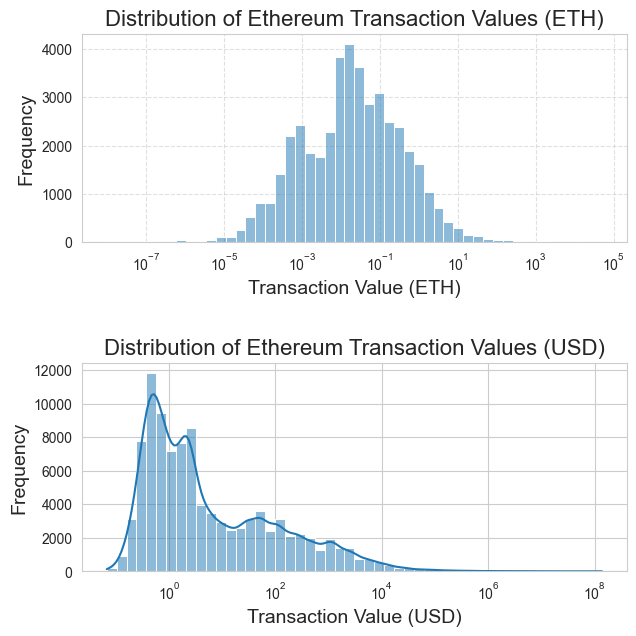

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7))

sns.histplot(df['value'], bins=50, log_scale=True, kde=True, ax=ax[0])

ax[0].set_xlabel("Transaction Value (ETH)", fontsize=14)
ax[0].set_ylabel("Frequency", fontsize=14)
ax[0].set_title("Distribution of Ethereum Transaction Values (ETH)", fontsize=16)
ax[0].grid(True, linestyle="--", alpha=0.6)


sns.histplot(df['total_cost_usd'], bins=50, log_scale=(True, False), kde=True, ax=ax[1])

ax[1].set_xlabel("Transaction Value (USD)", fontsize=14)
ax[1].set_ylabel("Frequency", fontsize=14)
ax[1].set_title("Distribution of Ethereum Transaction Values (USD)", fontsize=16)
ax[0].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout(pad=3)


plt.show()
